# Imports

In [1]:
!pip install -q mapie

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.metrics import mean_squared_error, r2_score
from mapie.regression import MapieRegressor, MapieQuantileRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import Subsample

In [3]:
# Set environment and suppress warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# Load the Data

In [4]:
# Load the data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Display the data
display(df.head())

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

# Prepare the Data

In [5]:
# Prepare the data
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16512, 8)
X_test shape: (4128, 8)
y_train shape: (16512,)
y_test shape: (4128,)


# Define the Models

In [7]:
# Define base models and a stacking model
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
stacked_model = StackingRegressor(
    estimators=[('ridge', ridge), ('lasso', lasso), ('tree', tree)],
    final_estimator=LinearRegression()
)

In [8]:
# Define models and methods
models = {
    "Ridge": ridge,
    "Lasso": lasso,
    "Decision Tree": tree,
    "Stacked Model": stacked_model
}
methods = ["naive", "base", "plus", "minmax"]

# Model Evaluation

In [9]:
# Function to evaluate models using MAPIE with various methods and alpha levels
def evaluate_models(models, methods, alpha_values, X_train, y_train, X_test, y_test):
    results = {}

    for model_name, model in models.items():
        model_results = {}

        for method in methods:
            mapie = MapieRegressor(model, method=method)
            mapie.fit(X_train, y_train)
            y_pred, y_pis = mapie.predict(X_test, alpha=alpha_values)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])

            model_results[method] = {
                "mse": mse,
                "r2": r2,
                "coverage": coverage,
                "y_pred": y_pred,
                "y_pis": y_pis
            }

            print(f"{model_name} - Method: {method.capitalize()}")
            print(f"Mean Squared Error: {mse:.4f}")
            print(f"R-squared: {r2:.4f}")
            print(f"Coverage at 90% interval: {coverage:.4f}\n")

        results[model_name] = model_results

    return results

In [10]:
# Evaluate the models
results = evaluate_models(models, methods, alpha_values=[0.1, 0.05, 0.01],
                          X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Ridge - Method: Naive
Mean Squared Error: 0.5558
R-squared: 0.5759
Coverage at 90% interval: 0.8997

Ridge - Method: Base
Mean Squared Error: 0.5558
R-squared: 0.5759
Coverage at 90% interval: 0.9000

Ridge - Method: Plus
Mean Squared Error: 0.5558
R-squared: 0.5759
Coverage at 90% interval: 0.8997

Ridge - Method: Minmax
Mean Squared Error: 0.5558
R-squared: 0.5759
Coverage at 90% interval: 0.9014

Lasso - Method: Naive
Mean Squared Error: 0.9380
R-squared: 0.2842
Coverage at 90% interval: 0.9021

Lasso - Method: Base
Mean Squared Error: 0.9380
R-squared: 0.2842
Coverage at 90% interval: 0.9021

Lasso - Method: Plus
Mean Squared Error: 0.9380
R-squared: 0.2842
Coverage at 90% interval: 0.9024

Lasso - Method: Minmax
Mean Squared Error: 0.9380
R-squared: 0.2842
Coverage at 90% interval: 0.9033

Decision Tree - Method: Naive
Mean Squared Error: 0.4988
R-squared: 0.6194
Coverage at 90% interval: 0.0109

Decision Tree - Method: Base
Mean Squared Error: 0.5020
R-squared: 0.6169
Coverage at

In [11]:
# Plotting function for predictions and intervals
def plot_predictions(results, y_test, alpha_values, selected_alpha=0.05, legend_position='top'):
    plt.figure(figsize=(16, 10))
    n_models = len(results)
    n_methods = len(methods)

    for i, (model_name, model_results) in enumerate(results.items()):
        for j, method in enumerate(methods):
            y_pred = model_results[method]["y_pred"]
            y_pis = model_results[method]["y_pis"]

            plt.subplot(n_models, n_methods, i*n_methods + j + 1)
            plt.plot(np.arange(len(y_test)), y_test, "b.", label="True values", alpha=0.7)
            plt.plot(np.arange(len(y_test)), y_pred, "r-", label="Predictions", alpha=0.7)

            # Plot the selected prediction interval
            if selected_alpha in alpha_values:
                alpha_index = alpha_values.index(selected_alpha)
                plt.fill_between(np.arange(len(y_test)),
                                 y_pis[:, 0, alpha_index],
                                 y_pis[:, 1, alpha_index],
                                 color="orange", alpha=0.2, label=f"{int((1-selected_alpha)*100)}% PI")

            plt.xlabel("Sample Index")
            plt.ylabel("Median House Value")
            plt.title(f"{model_name} - {method.capitalize()} Method")

    # Create a global legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if legend_position == 'top':
        plt.figlegend(handles, labels, loc='upper center', ncol=3, fontsize='small')
    elif legend_position == 'bottom':
        plt.figlegend(handles, labels, loc='lower center', ncol=3, fontsize='small')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

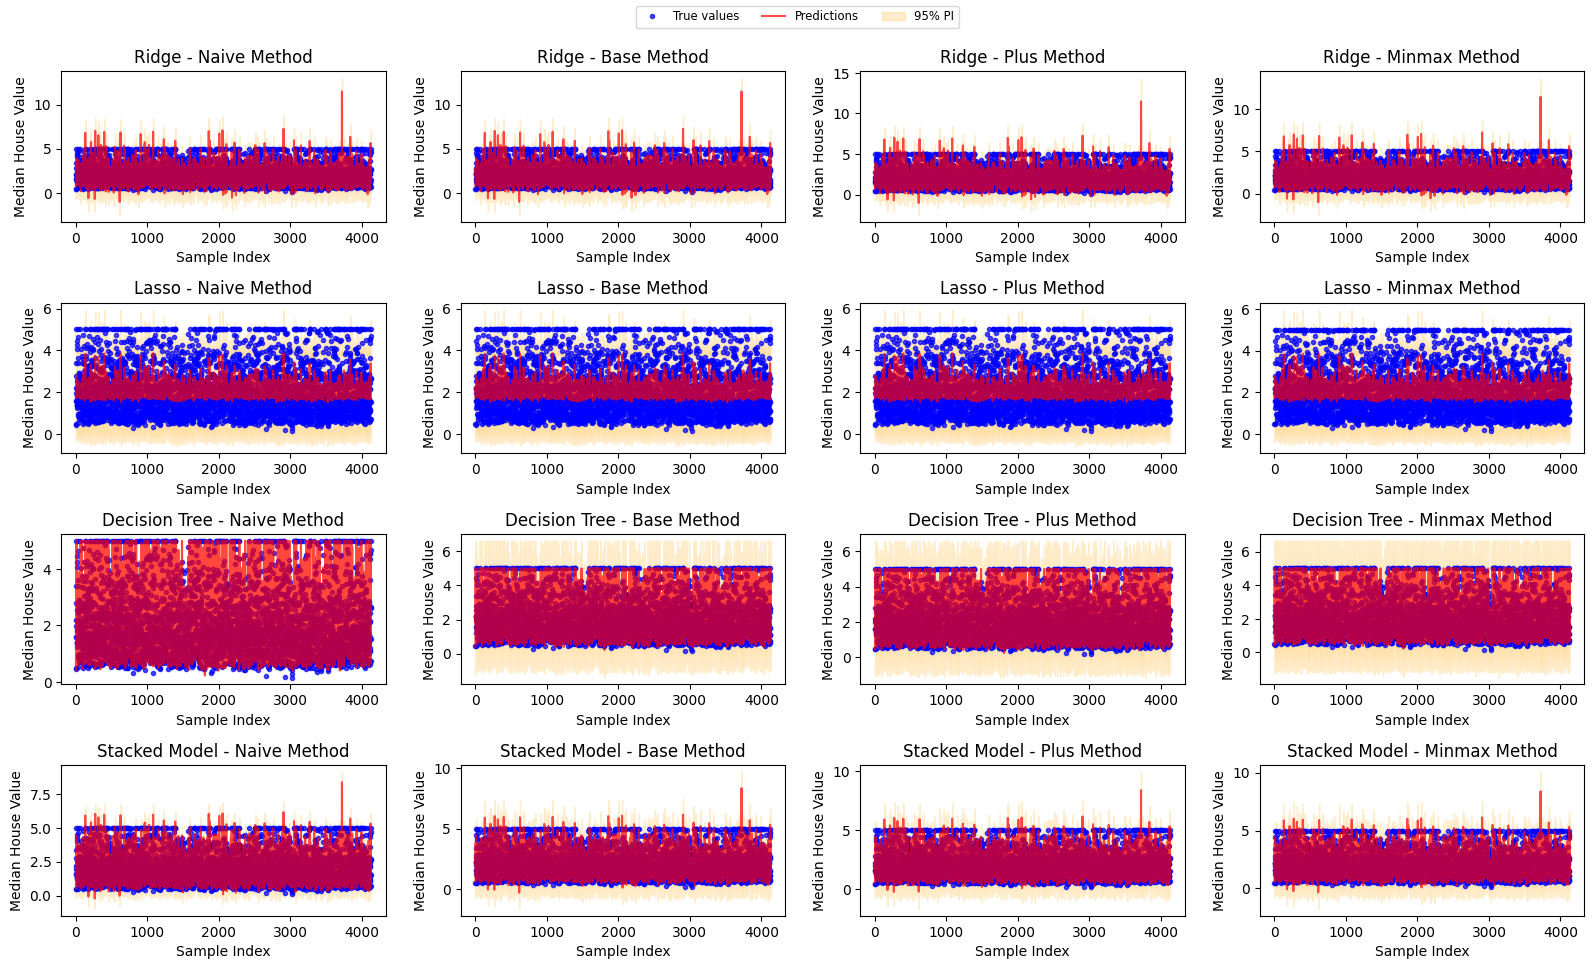

In [12]:
# Plot the results
alpha_values = [0.1, 0.05, 0.01]
plot_predictions(results, y_test, alpha_values, selected_alpha=0.05)

In [13]:
# Analyze different confidence levels (alpha) for Ridge with the "plus" method
alphas = [0.2, 0.1, 0.05, 0.01]
mapie_conf_levels = MapieRegressor(ridge, method="plus")
mapie_conf_levels.fit(X_train, y_train)
y_pred_conf_levels, y_pis_conf_levels = mapie_conf_levels.predict(X_test, alpha=alphas)

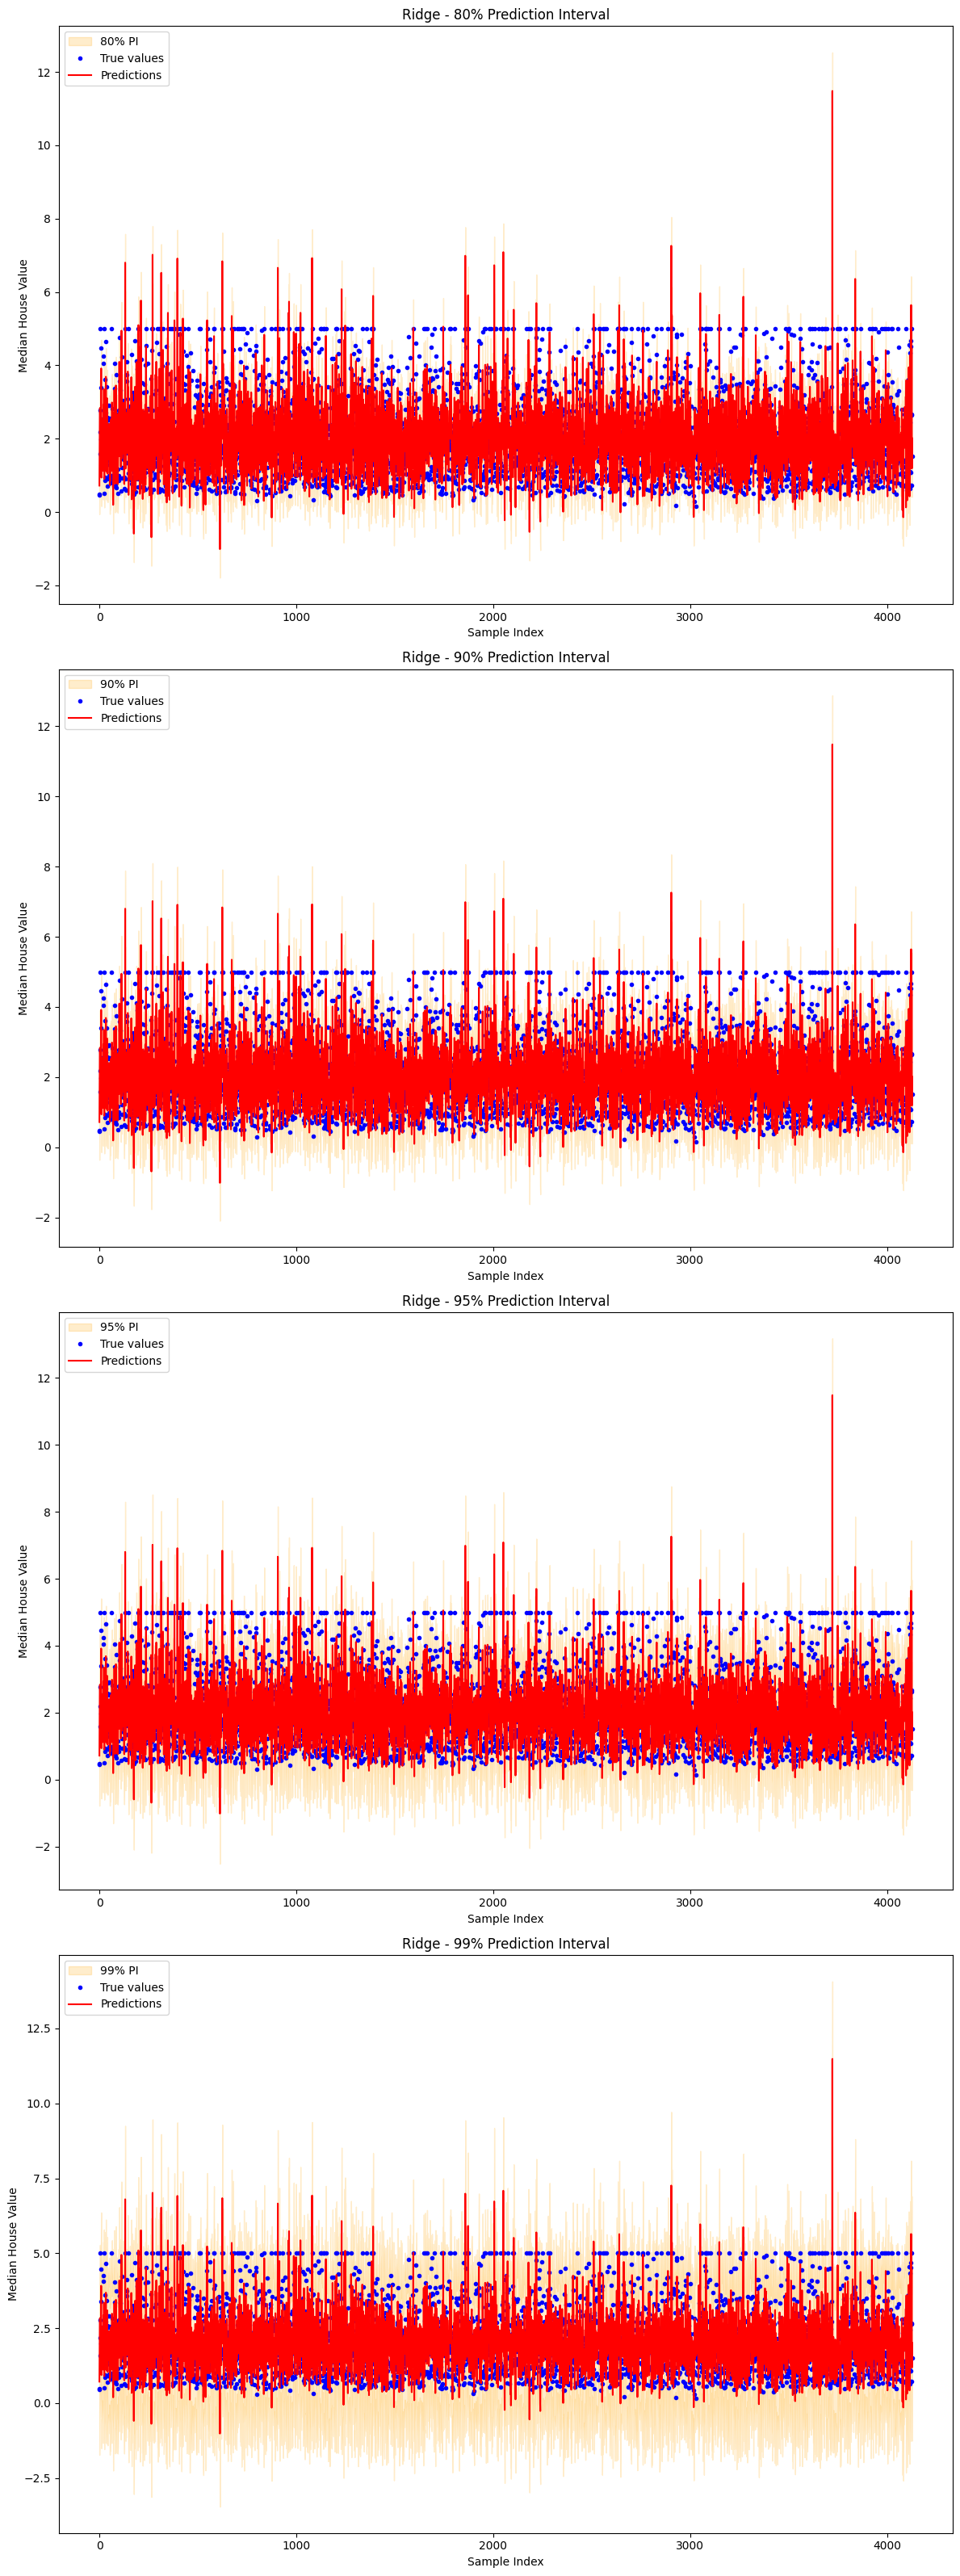

In [14]:
# Plotting each prediction interval in a separate subplot
n_intervals = len(alphas)
fig, axs = plt.subplots(n_intervals, 1, figsize=(12, 8 * n_intervals))

for i, alpha in enumerate(alphas):
    ax = axs[i] if n_intervals > 1 else axs
    ax.fill_between(np.arange(len(y_test)),
                    y_pis_conf_levels[:, 0, i],
                    y_pis_conf_levels[:, 1, i],
                    color="orange", alpha=0.2, label=f"{int((1-alpha)*100)}% PI")
    ax.plot(np.arange(len(y_test)), y_test, "b.", label="True values")
    ax.plot(np.arange(len(y_test)), y_pred_conf_levels, "r-", label="Predictions")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Median House Value")
    ax.set_title(f"Ridge - {int((1-alpha)*100)}% Prediction Interval")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [15]:
# Hyperparameter tuning with Ridge model
param_dist = {'alpha': np.logspace(-3, 3, 100)}
ridge_search = RandomizedSearchCV(Ridge(), param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, random_state=42)
ridge_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
                   random_state=42)

In [16]:
# Evaluate the best Ridge model with MAPIE
best_ridge = ridge_search.best_estimator_
mapie_best_ridge = MapieRegressor(best_ridge, method="plus")
mapie_best_ridge.fit(X_train, y_train)
y_pred_best_ridge, y_pis_best_ridge = mapie_best_ridge.predict(X_test, alpha=[0.1, 0.05, 0.01])

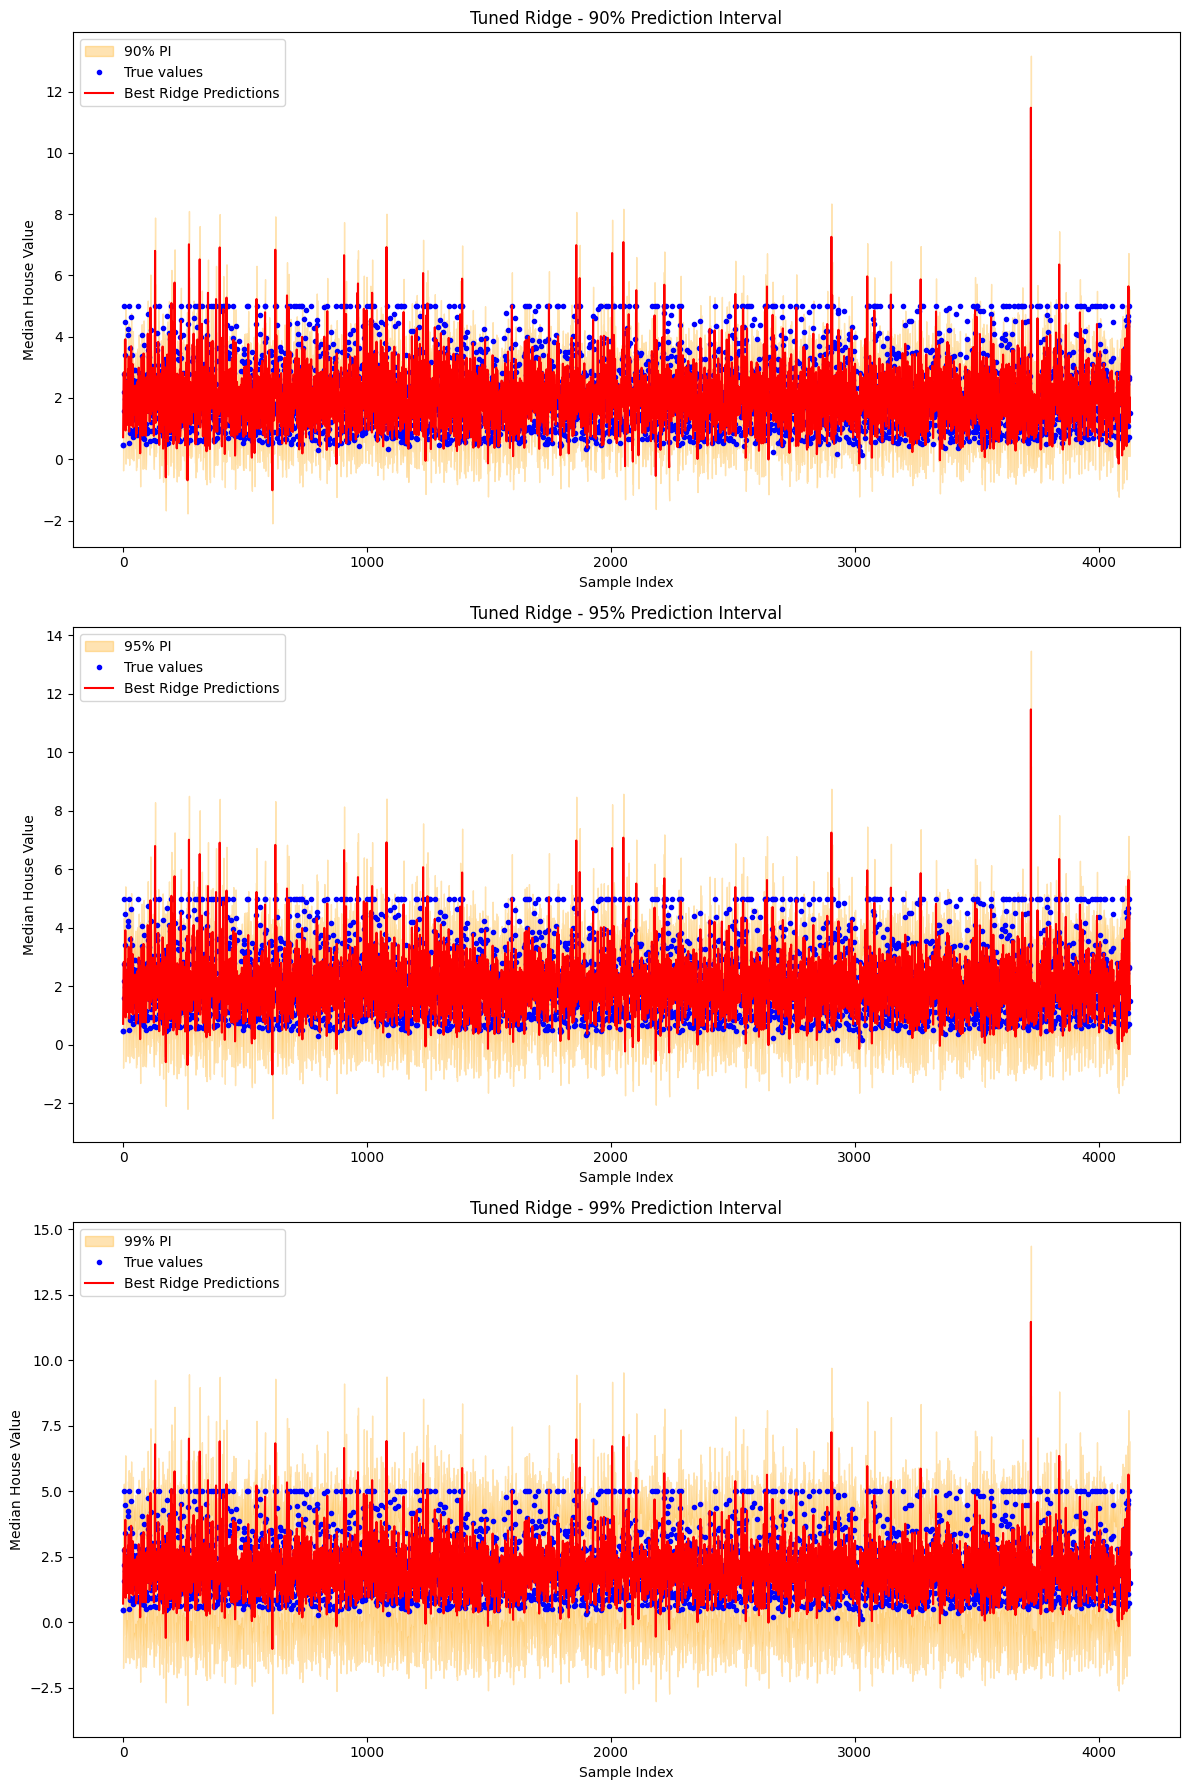

In [17]:
# Define the alpha values for the prediction intervals
alpha_values = [0.1, 0.05, 0.01]

# Plotting each prediction interval in a separate subplot
n_intervals = len(alpha_values)
fig, axs = plt.subplots(n_intervals, 1, figsize=(12, 6 * n_intervals))

for i, alpha in enumerate(alpha_values):
    ax = axs[i] if n_intervals > 1 else axs
    ax.fill_between(np.arange(len(y_test)),
                    y_pis_best_ridge[:, 0, i],
                    y_pis_best_ridge[:, 1, i],
                    color="orange", alpha=0.3, label=f"{int((1-alpha)*100)}% PI")
    ax.plot(np.arange(len(y_test)), y_test, "b.", label="True values")
    ax.plot(np.arange(len(y_test)), y_pred_best_ridge, "r-", label="Best Ridge Predictions")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Median House Value")
    ax.set_title(f"Tuned Ridge - {int((1-alpha)*100)}% Prediction Interval")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Symmetric vs. Asymmetric

In [18]:
# Define the estimator
alpha_qr = 0.2
gb_reg = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)

In [19]:
# MAPIE Quantile Regressor
mapie_qr = MapieQuantileRegressor(estimator=gb_reg, alpha=alpha_qr)

# Fit the model on the training data
mapie_qr.fit(X_train, y_train, random_state=42)

MapieQuantileRegressor(alpha=0.2, cv='split',
                       estimator=GradientBoostingRegressor(alpha=0.5,
                                                           loss='quantile',
                                                           random_state=42))

In [20]:
# Make predictions and calculate prediction intervals
y_pred_sym, y_pis_sym = mapie_qr.predict(X_test, symmetry=True)
y_pred_asym, y_pis_asym = mapie_qr.predict(X_test, symmetry=False)

In [21]:
# Calculate coverage scores
coverage_score_sym = regression_coverage_score(y_test, y_pis_sym[:, 0], y_pis_sym[:, 1])
coverage_score_asym = regression_coverage_score(y_test, y_pis_asym[:, 0], y_pis_asym[:, 1])

print(f"Symmetric Coverage Score: {coverage_score_sym:.3f}")
print(f"Asymmetric Coverage Score: {coverage_score_asym:.3f}")

Symmetric Coverage Score: 0.793
Asymmetric Coverage Score: 0.794


In [22]:
# Squeeze the y_pis objects
y_pis_sym = np.squeeze(y_pis_sym)
y_pis_asym = np.squeeze(y_pis_asym)

# Sort the data for plotting
order = np.argsort(X_test.iloc[:, 0].values)
X_test_sorted = X_test.iloc[order]
y_test_sorted = y_test.iloc[order]
y_pred_sym_sorted = y_pred_sym[order]
y_pred_asym_sorted = y_pred_asym[order]
y_pis_sym_sorted = y_pis_sym[order]
y_pis_asym_sorted = y_pis_asym[order]

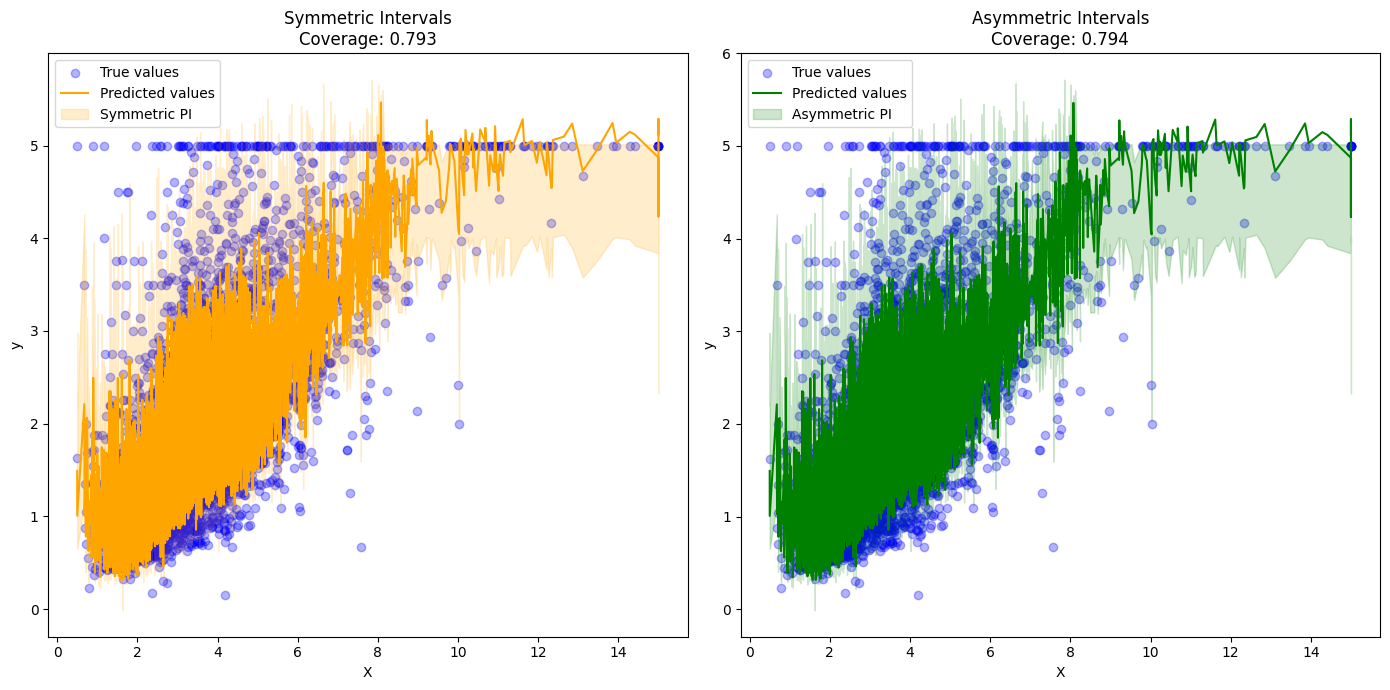

In [23]:
# Plot symmetric prediction intervals
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_test_sorted.iloc[:, 0], y_test_sorted, alpha=0.3, color="blue", label="True values")
plt.plot(X_test_sorted.iloc[:, 0], y_pred_sym_sorted, color="orange", label="Predicted values")
plt.fill_between(
    X_test_sorted.iloc[:, 0],
    y_pis_sym_sorted[:, 0],  # Lower bound
    y_pis_sym_sorted[:, 1],  # Upper bound
    color="orange",
    alpha=0.2,
    label="Symmetric PI"
)
plt.title(f"Symmetric Intervals\nCoverage: {coverage_score_sym:.3f}")
plt.legend()

# Plot asymmetric prediction intervals
plt.subplot(1, 2, 2)
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_test_sorted.iloc[:, 0], y_test_sorted, alpha=0.3, color="blue", label="True values")
plt.plot(X_test_sorted.iloc[:, 0], y_pred_asym_sorted, color="green", label="Predicted values")
plt.fill_between(
    X_test_sorted.iloc[:, 0],
    y_pis_asym_sorted[:, 0],  # Lower bound
    y_pis_asym_sorted[:, 1],  # Upper bound
    color="green",
    alpha=0.2,
    label="Asymmetric PI"
)
plt.title(f"Asymmetric Intervals\nCoverage: {coverage_score_asym:.3f}")
plt.legend()

plt.tight_layout()
plt.show()

# Polynomial Models

In [24]:
# Split data into training, testing, and calibration sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [25]:
# Define polynomial regression models
def create_polynomial_models(degree=3):
    polyn_model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("linear", LinearRegression())
    ])
    polyn_model_quant = Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("linear", QuantileRegressor(solver="highs", alpha=0))
    ])
    return polyn_model, polyn_model_quant

polyn_model, polyn_model_quant = create_polynomial_models()

In [26]:
# Define subsampling strategies
STRATEGIES = {
    "naive": {"model": polyn_model, "method": "naive"},
    "jackknife": {"model": polyn_model, "method": "base", "cv": -1},
    "jackknife_plus": {"model": polyn_model, "method": "plus", "cv": -1},
    "jackknife_minmax": {"model": polyn_model, "method": "minmax", "cv": -1},
    "cv": {"model": polyn_model, "method": "base", "cv": 3},
    "cv_plus": {"model": polyn_model, "method": "plus", "cv": 3},
    "cv_minmax": {"model": polyn_model, "method": "minmax", "cv": 3},
    "jackknife_plus_ab": {"model": polyn_model, "method": "plus", "cv": Subsample(n_resamplings=3)},
    "jackknife_minmax_ab": {"model": polyn_model, "method": "minmax", "cv": Subsample(n_resamplings=3)},
    "cqr": {"model": polyn_model_quant, "method": "quantile", "cv": "split", "alpha": 0.05},
}

In [27]:
# Function to sort y values
def sort_y_values(y_test, y_pred, y_pis):
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

In [28]:
# Initialize storage for results
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}

# Fit and predict using the strategies
for strategy, params in STRATEGIES.items():
    print(f"Running strategy: '{strategy}'...")
    try:
        model = params.pop("model")
        if strategy == "cqr":
            print(f"Using MapieQuantileRegressor with params: {params}")
            print(f"Model = {model}")
            mapie = MapieQuantileRegressor(estimator=model, **params)
            mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib, random_state=42)
            prediction_result = mapie.predict(X_test)
        else:
            print(f"Using MapieRegressor with params: {params}")
            print(f"Model = {model}")
            mapie = MapieRegressor(estimator=model, **params, random_state=42)
            mapie.fit(X_train, y_train)
            prediction_result = mapie.predict(X_test, alpha=0.2)

        # Check if prediction_result is None
        if prediction_result is None:
            raise ValueError(f"Prediction returned None for strategy: {strategy}")

        # Unpack the results according to the number of returned values
        if len(prediction_result) == 2:
            y_pred[strategy], y_pis[strategy] = prediction_result
        elif len(prediction_result) == 3:
            y_pred[strategy], y_pis[strategy], _ = prediction_result
        else:
            raise ValueError(f"Unexpected output from mapie.predict() for strategy '{strategy}'")

        # Debugging: Print the shapes of the predictions and prediction intervals
        print(f"Shape of y_pred[strategy]: {y_pred[strategy].shape}")
        print(f"Shape of y_pis[strategy]: {y_pis[strategy].shape}")

        # Check for NaN values in prediction intervals
        if np.isnan(y_pis[strategy]).all():
            raise ValueError(f"Prediction intervals contain only NaN values for strategy: {strategy}")

        # Print details about the sorted values
        (
            y_test_sorted[strategy],
            y_pred_sorted[strategy],
            lower_bound[strategy],
            upper_bound[strategy]
        ) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])

        # Calculate coverage and width
        coverage[strategy] = regression_coverage_score(
            y_test,
            y_pis[strategy][:, 0, 0],
            y_pis[strategy][:, 1, 0]
        )
        width[strategy] = regression_mean_width_score(
            y_pis[strategy][:, 0, 0],
            y_pis[strategy][:, 1, 0]
        )

        print(f"Strategy '{strategy}' completed successfully with coverage: {coverage[strategy]:.4f} and width: {width[strategy]:.4f}\n")

    except Exception as e:
        print(f"\nERROR encountered with strategy '{strategy}': {e}")
        print(f"Error Type: {type(e).__name__}\n")
        continue

print("Finished processing all strategies.")

Running strategy: 'naive'...
Using MapieRegressor with params: {'method': 'naive'}
Model = Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression())])
Shape of y_pred[strategy]: (4128,)
Shape of y_pis[strategy]: (4128, 2, 1)
Strategy 'naive' completed successfully with coverage: 0.7968 and width: 1.2588

Running strategy: 'jackknife'...
Using MapieRegressor with params: {'method': 'base', 'cv': -1}
Model = Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression())])
Shape of y_pred[strategy]: (4128,)
Shape of y_pis[strategy]: (4128, 2, 1)
Strategy 'jackknife' completed successfully with coverage: 0.8009 and width: 1.2817

Running strategy: 'jackknife_plus'...
Using MapieRegressor with params: {'method': 'plus', 'cv': -1}
Model = Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression())])
Shape of y_pred[strategy]: (4128,)
Shape of y_pis[strategy]: (4128,

In [29]:
# Function to plot prediction intervals
def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_ - lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_ + error
    warning2 = y_test_sorted_ < y_pred_sorted_ - error
    warnings = warning1 | warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
    )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
    )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True values")
    axs.set_ylabel("Predictions")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, 3)}\nInterval width: {np.round(width, 3)}"
        ),
        xy=(np.min(y_test_sorted_) * 1.05, np.max(y_pred_sorted_ + error) * 0.95),
    )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),
        np.max([axs.get_xlim(), axs.get_ylim()]),
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

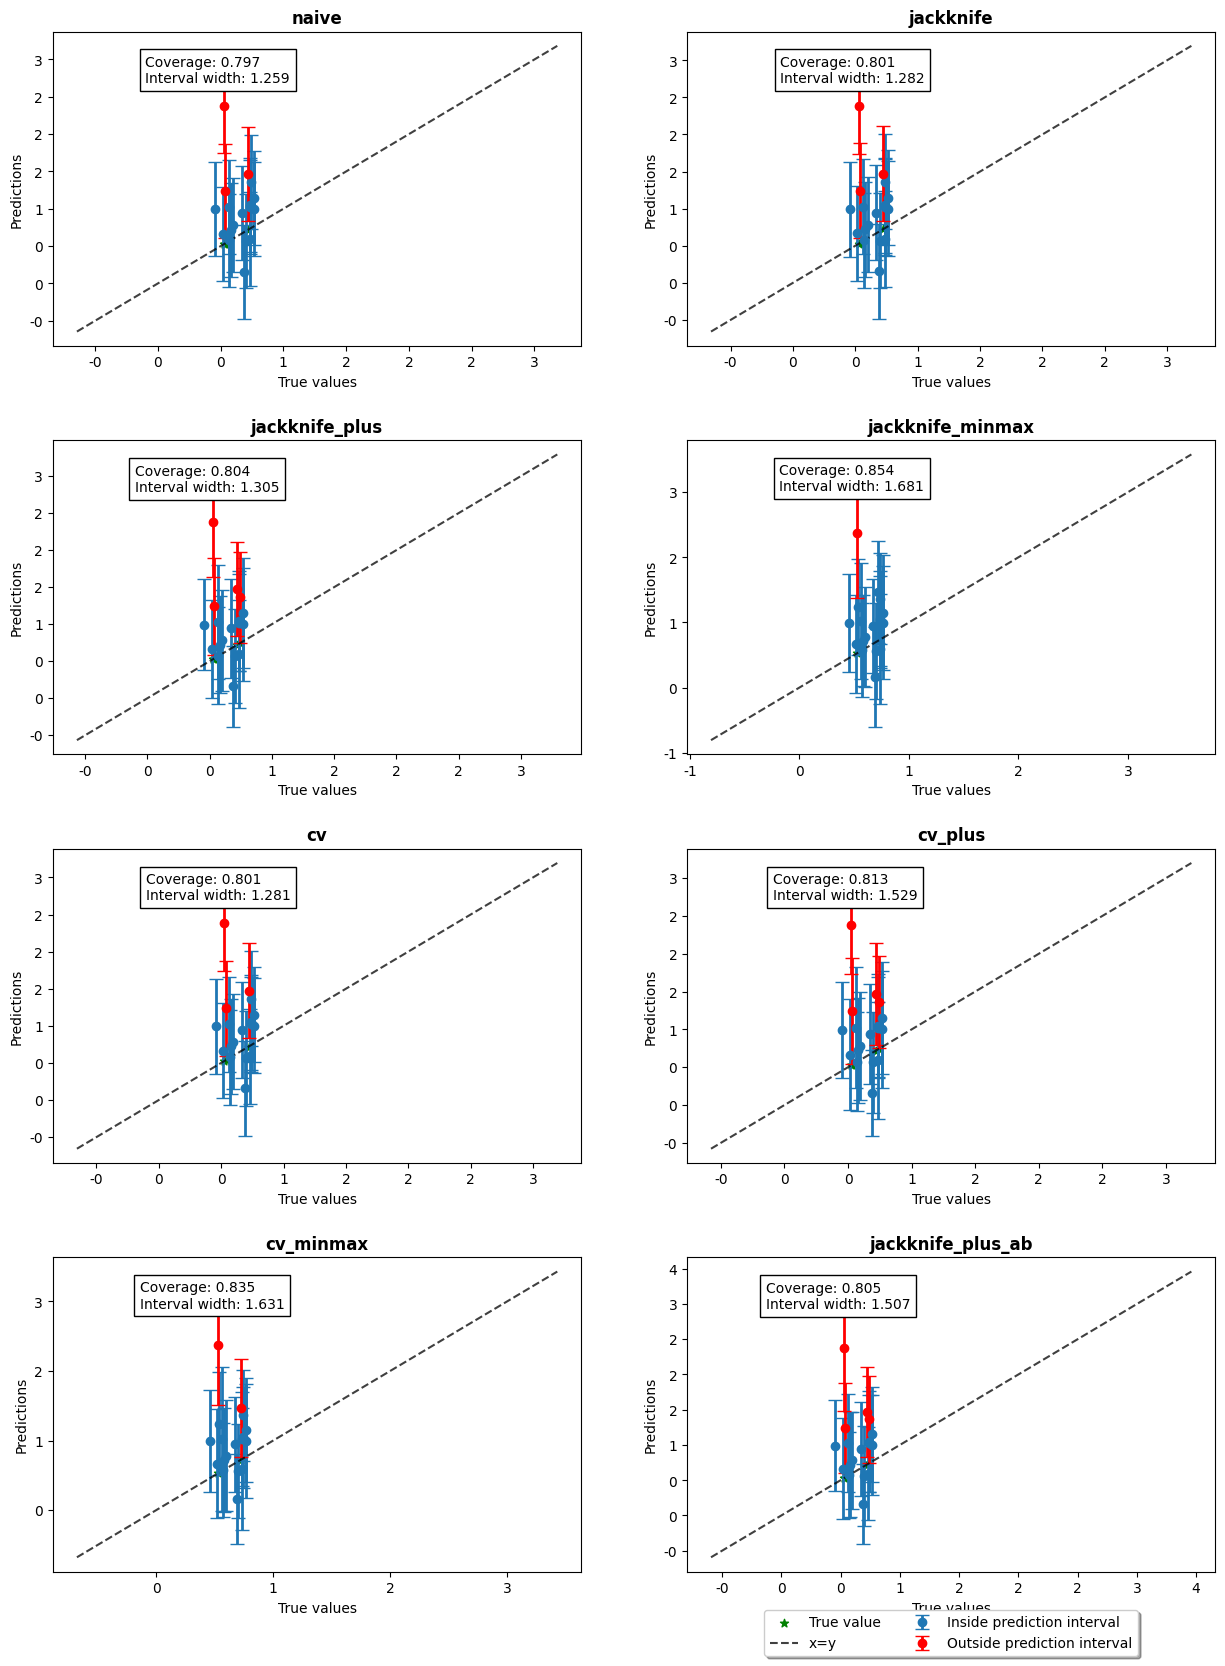

In [55]:
# Define the proportion of data points to plot
perc_obs_plot = 0.05
num_plots = np.random.choice(len(y_test), int(perc_obs_plot * len(y_test)), replace=False)

# Dynamic Plotting
successful_strategies = [strategy for strategy in STRATEGIES.keys() if strategy in y_test_sorted]
n_strategies = len(successful_strategies)
ncols = 2  # Number of columns
nrows = (n_strategies + ncols - 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
axs = axs.flatten()  # Flatten the axes array for easy indexing

# Plot each strategy
for i, strategy in enumerate(successful_strategies):
    plot_prediction_intervals(
        strategy,
        axs[i],
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy],
        coverage[strategy],
        width[strategy],
        num_plots
    )

# Hide any remaining empty subplots
for ax in axs[len(successful_strategies):]:
    ax.axis('off')

# Adjust the space between plots
plt.subplots_adjust(hspace=0.3)

# Shared legend setup
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes if ax.has_data()]
lines, labels = [sum(x, []) for x in zip(*lines_labels)]
plt.legend(lines[:4], labels[:4], loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()

# Time Series Forecasting

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor
import matplotlib.pyplot as plt
from scipy.stats import randint
import warnings

warnings.filterwarnings("ignore")

In [32]:
# Load the data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=["Date"], index_col="Date")

# Display the data
display(df.head())

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [33]:
# Create datetime features
df['Dayofweek'] = df.index.dayofweek
df['Month'] = df.index.month

# Create lag features
n_lags = 7  # A week's worth of lags
for lag in range(1, n_lags + 1):
    df[f'Lag_{lag}'] = df['Temp'].shift(lag)

# Drop missing values that result from lagging
df = df.dropna()

# Display the data after feature engineering
display(df.head())

Temp  Dayofweek  Month  Lag_1  Lag_2  Lag_3  Lag_4  Lag_5  Lag_6  \
Date                                                                           
1981-01-08  17.4          3      1   15.8   15.8   15.8   14.6   18.8   17.9   
1981-01-09  21.8          4      1   17.4   15.8   15.8   15.8   14.6   18.8   
1981-01-10  20.0          5      1   21.8   17.4   15.8   15.8   15.8   14.6   
1981-01-11  16.2          6      1   20.0   21.8   17.4   15.8   15.8   15.8   
1981-01-12  13.3          0      1   16.2   20.0   21.8   17.4   15.8   15.8   

            Lag_7  
Date               
1981-01-08   20.7  
1981-01-09   17.9  
1981-01-10   18.8  
1981-01-11   14.6  
1981-01-12   15.8

In [34]:
# Define the number of test steps
num_test_steps = 365  # Use the last year for testing

# Split the data into training and testing sets
df_train = df.iloc[:-num_test_steps, :].copy()
df_test = df.iloc[-num_test_steps:, :].copy()

# Define features and target
features = ['Dayofweek', 'Month'] + [f'Lag_{lag}' for lag in range(1, n_lags + 1)]
X_train = df_train[features]
y_train = df_train['Temp']
X_test = df_test[features]
y_test = df_test['Temp']

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3278, 9)
y_train shape: (3278,)
X_test shape: (365, 9)
y_test shape: (365,)


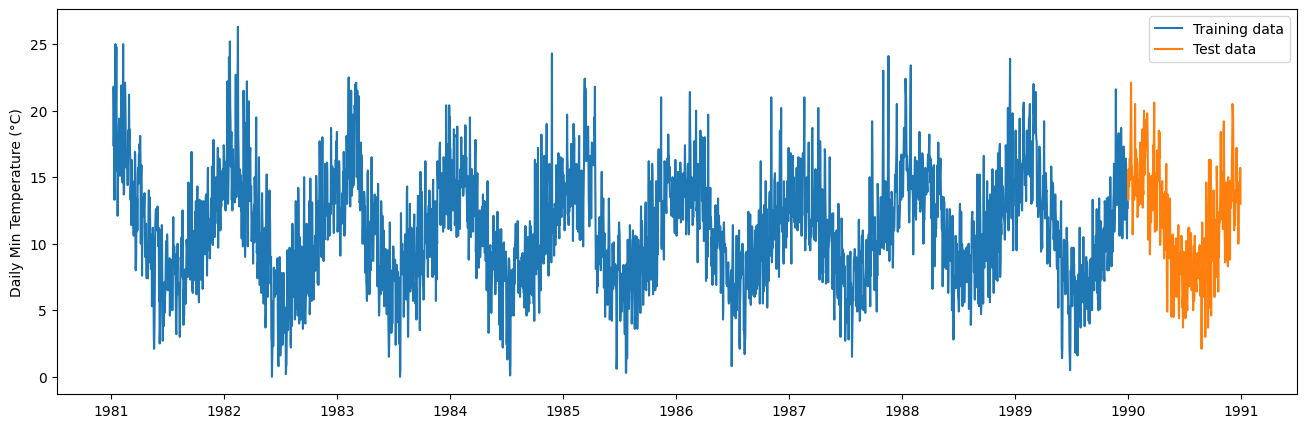

In [35]:
# Visualize the training and test data
plt.figure(figsize=(16, 5))
plt.plot(y_train, label='Training data')
plt.plot(y_test, label='Test data')
plt.ylabel("Daily Min Temperature (°C)")
plt.legend()
plt.show()

In [36]:
# Global parameters
alpha = 0.05
gap = 1
random_state = 42
n_resamplings = 10
n_blocks = 10
n_jobs = -1
n_splits = 5

In [37]:
# Function to optimize the model
def optimize_model(X_train, y_train, n_iter=100):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        n_jobs=n_jobs,
    )
    cv_obj.fit(X_train, y_train)
    return cv_obj.best_estimator_

In [38]:
# Model optimization
model_params_fit_not_done = True
if model_params_fit_not_done:
    model = optimize_model(X_train, y_train)
else:
    model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=random_state)

In [39]:
# Set up Block Bootstrap
cv_mapiets = BlockBootstrap(
    n_resamplings=n_resamplings,
    n_blocks=n_blocks,
    overlapping=False,
    random_state=random_state
)

In [40]:
# Set up the models
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=n_jobs
)

mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs=n_jobs
)

In [41]:
# Fit the models on the training set
mapie_enbpi.fit(X_train, y_train)
mapie_aci.fit(X_train, y_train)

MapieTimeSeriesRegressor(cv=BlockBootstrap(length=None, n_blocks=10, n_resamplings=10, overlapping=False,
        random_state=42),
                         estimator=RandomForestRegressor(max_depth=6,
                                                         n_estimators=60,
                                                         random_state=42),
                         method='aci', n_jobs=-1)

In [42]:
# Initialize arrays to hold predictions and prediction intervals
y_pred_enbpi_pfit = np.zeros((len(X_test),))
y_pis_enbpi_pfit = np.zeros((len(X_test), 2, 1))

y_pred_aci_pfit = np.zeros((len(X_test),))
y_pis_aci_pfit = np.zeros((len(X_test), 2, 1))

In [43]:
# Make initial predictions for the first gap
y_pred_enbpi_pfit[:gap], y_pis_enbpi_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True, allow_infinite_bounds=True
)

y_pred_aci_pfit[:gap], y_pis_aci_pfit[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True, allow_infinite_bounds=True
)

In [44]:
# Print min and max
print("Min value:", y_train.min())
print("Max value:", y_train.max())

Min value: 0.0
Max value: 26.3


In [45]:
# Define the clip range based on the observed min and max values
clip_min = 0.0
clip_max = 27.0

In [46]:
# Iteratively update the model and make predictions for the remaining data
for step in range(gap, len(X_test), gap):
    # Perform partial fit with the new data chunk
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )

    # Predict and update the prediction intervals
    y_pred_enbpi_pfit[step:step + gap], y_pis_enbpi_pfit[step:step + gap, :, :] = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )
    y_pis_enbpi_pfit[step:step + gap, :, :] = np.clip(y_pis_enbpi_pfit[step:step + gap, :, :], clip_min, clip_max)

    # Perform adapt_conformal_inference for ACI method
    mapie_aci.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )

    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma=0.05
    )

    y_pred_aci_pfit[step:step + gap], y_pis_aci_pfit[step:step + gap, :, :] = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )
    y_pis_aci_pfit[step:step + gap, :, :] = np.clip(y_pis_aci_pfit[step:step + gap, :, :], clip_min, clip_max)

In [47]:
# Calculate coverage and width for evaluation
coverage_enbpi_pfit = regression_coverage_score(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
width_enbpi_pfit = regression_mean_width_score(
    y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)

coverage_aci_pfit = regression_coverage_score(
    y_test, y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0]
)
width_aci_pfit = regression_mean_width_score(
    y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0]
)

In [48]:
# Organize predictions and intervals for plotting
y_enbpi_preds = y_pred_enbpi_pfit
y_enbpi_pis = y_pis_enbpi_pfit
coverage_enbpi = coverage_enbpi_pfit
width_enbpi = width_enbpi_pfit

y_aci_preds = y_pred_aci_pfit
y_aci_pis = y_pis_aci_pfit
coverage_aci = coverage_aci_pfit
width_aci = width_aci_pfit

# Determine labels
y_label = "Daily Minimum Temperature (°C)"
x_label = "Date"

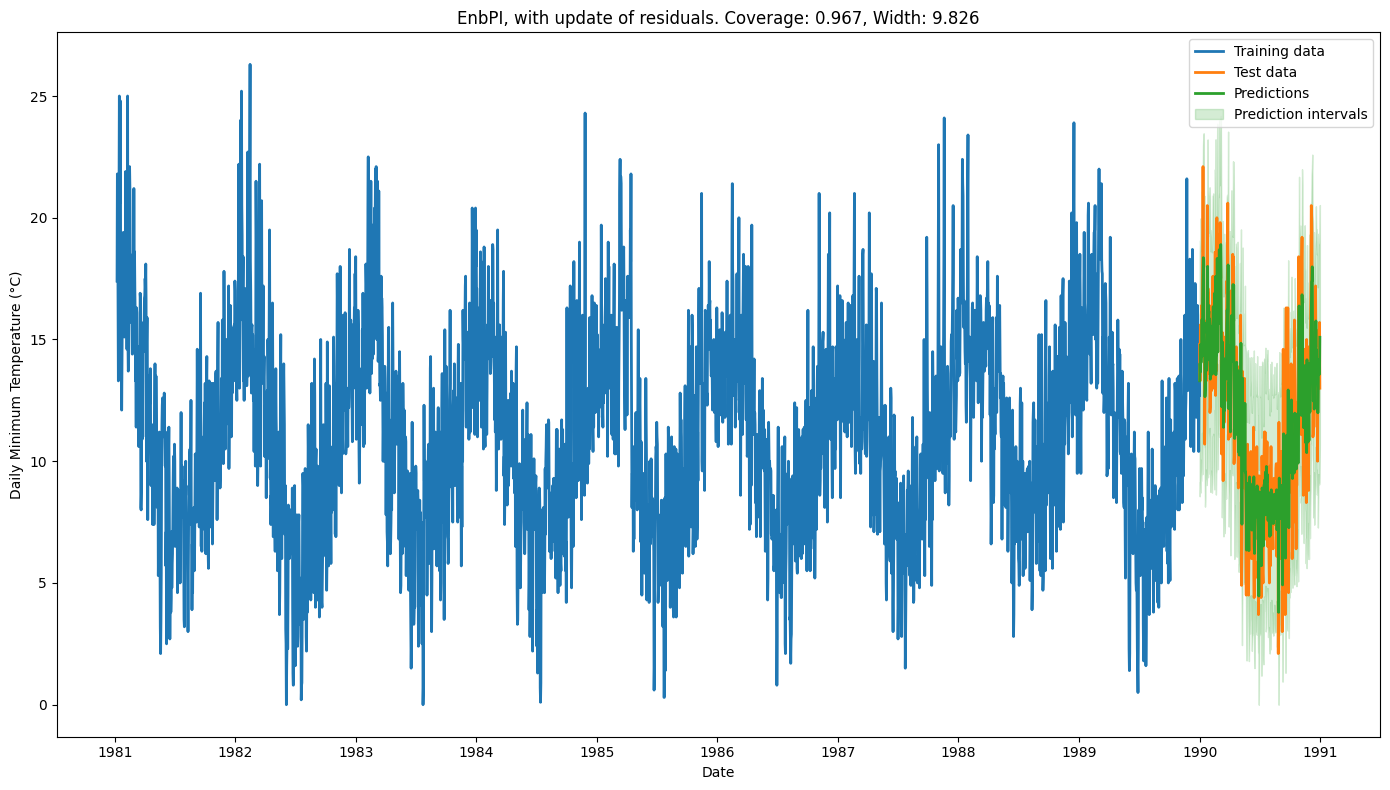

In [49]:
# Plotting for EnbPI
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.set_ylabel(y_label)
axs.set_xlabel(x_label)
axs.plot(y_train.index, y_train, lw=2, label="Training data", c="C0")
axs.plot(y_test.index, y_test, lw=2, label="Test data", c="C1")
axs.plot(y_test.index, y_enbpi_preds, lw=2, c="C2", label="Predictions")
axs.fill_between(
    y_test.index,
    y_enbpi_pis[:, 0, 0],
    y_enbpi_pis[:, 1, 0],
    color="C2",
    alpha=0.2,
    label="Prediction intervals",
)
title = f"EnbPI, with update of residuals. Coverage: {coverage_enbpi:.3f}, Width: {width_enbpi:.3f}"
axs.set_title(title)
axs.legend()
fig.tight_layout()
plt.show()

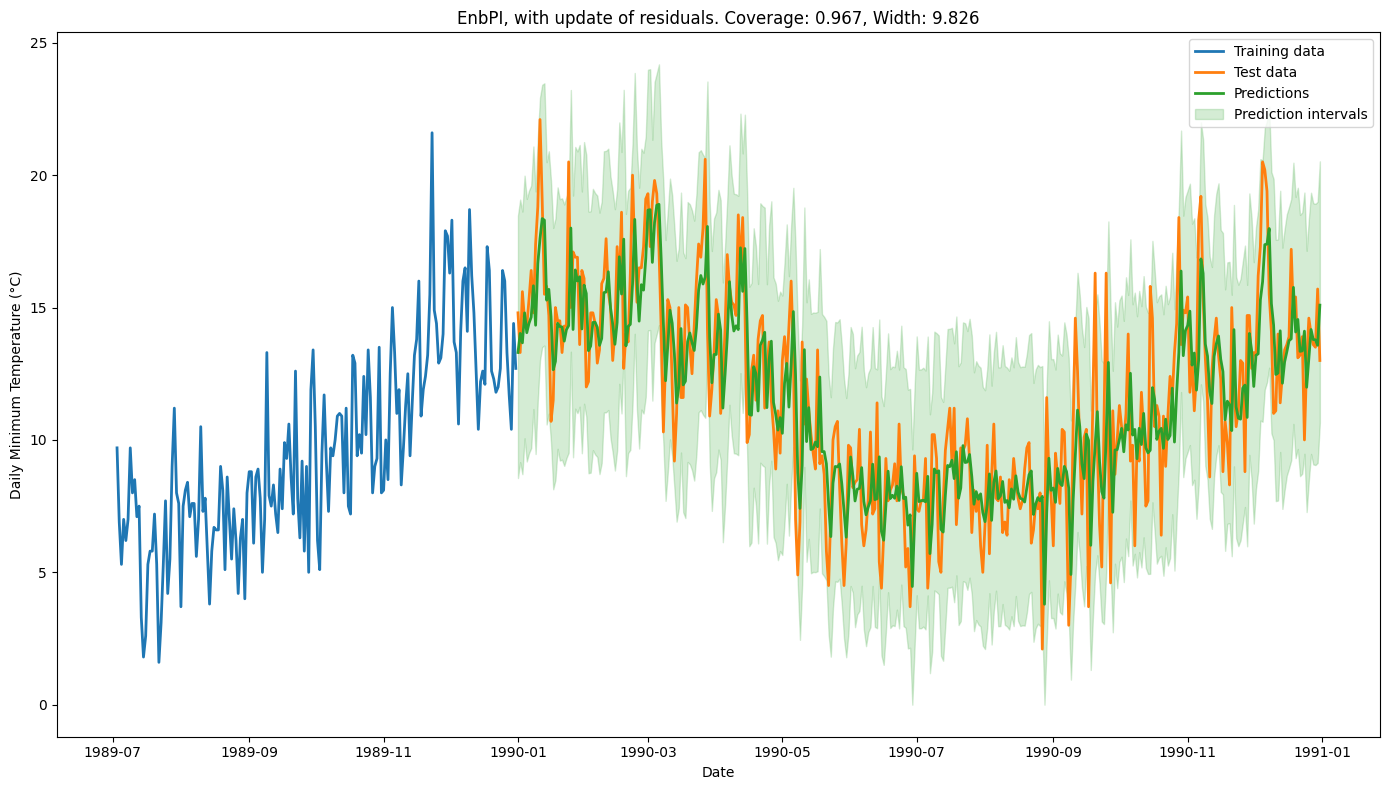

In [50]:
# Plotting for EnbPI
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.set_ylabel(y_label)
axs.set_xlabel(x_label)
axs.plot(y_train.index[int(-len(y_test)/2):], y_train[int(-len(y_test)/2):], lw=2, label="Training data", c="C0")
axs.plot(y_test.index, y_test, lw=2, label="Test data", c="C1")
axs.plot(y_test.index, y_enbpi_preds, lw=2, c="C2", label="Predictions")
axs.fill_between(
    y_test.index,
    y_enbpi_pis[:, 0, 0],
    y_enbpi_pis[:, 1, 0],
    color="C2",
    alpha=0.2,
    label="Prediction intervals",
)
title = f"EnbPI, with update of residuals. Coverage: {coverage_enbpi:.3f}, Width: {width_enbpi:.3f}"
axs.set_title(title)
axs.legend()
fig.tight_layout()
plt.show()

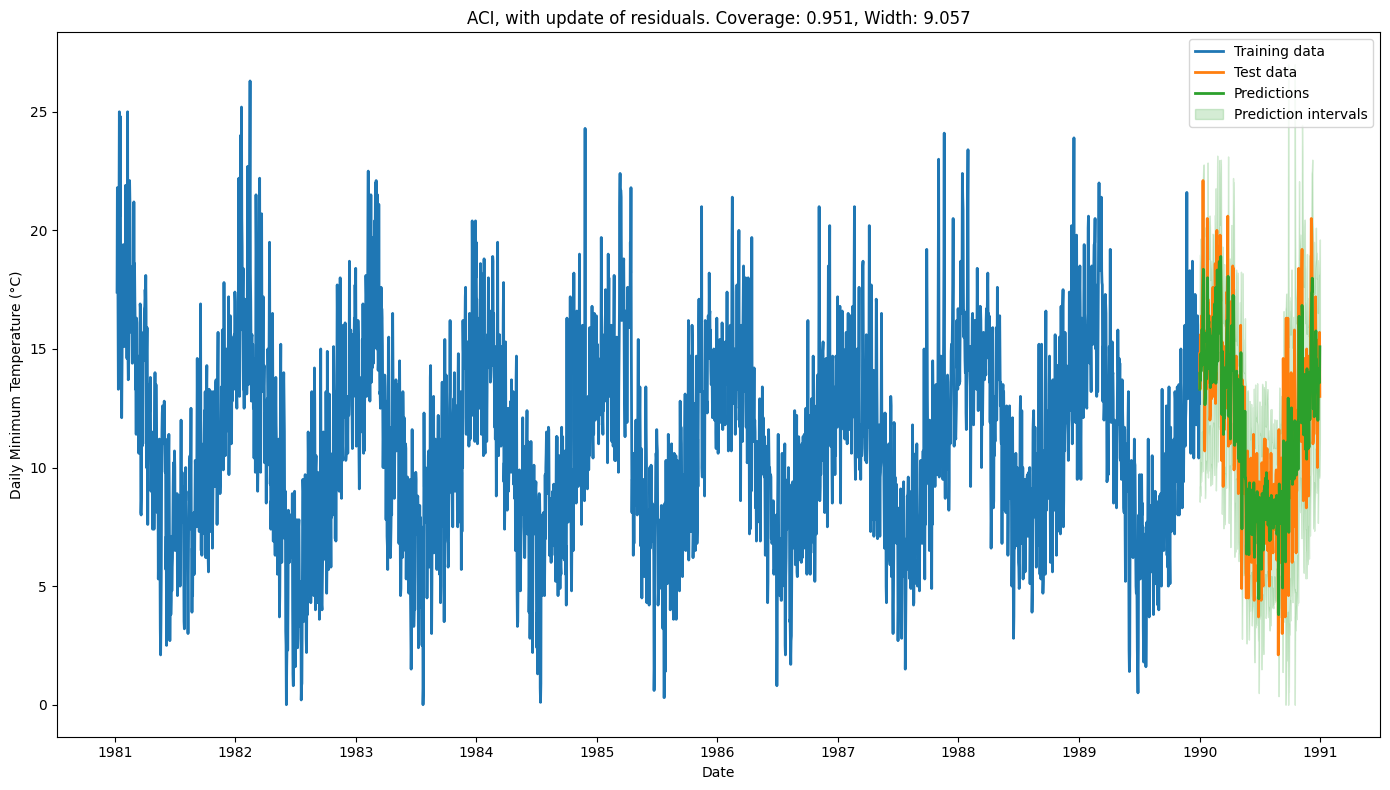

In [51]:
# Plotting for ACI
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.set_ylabel(y_label)
axs.set_xlabel(x_label)
axs.plot(y_train.index, y_train, lw=2, label="Training data", c="C0")
axs.plot(y_test.index, y_test, lw=2, label="Test data", c="C1")
axs.plot(y_test.index, y_aci_preds, lw=2, c="C2", label="Predictions")
axs.fill_between(
    y_test.index,
    y_aci_pis[:, 0, 0],
    y_aci_pis[:, 1, 0],
    color="C2",
    alpha=0.2,
    label="Prediction intervals",
)
title = f"ACI, with update of residuals. Coverage: {coverage_aci:.3f}, Width: {width_aci:.3f}"
axs.set_title(title)
axs.legend()
fig.tight_layout()
plt.show()

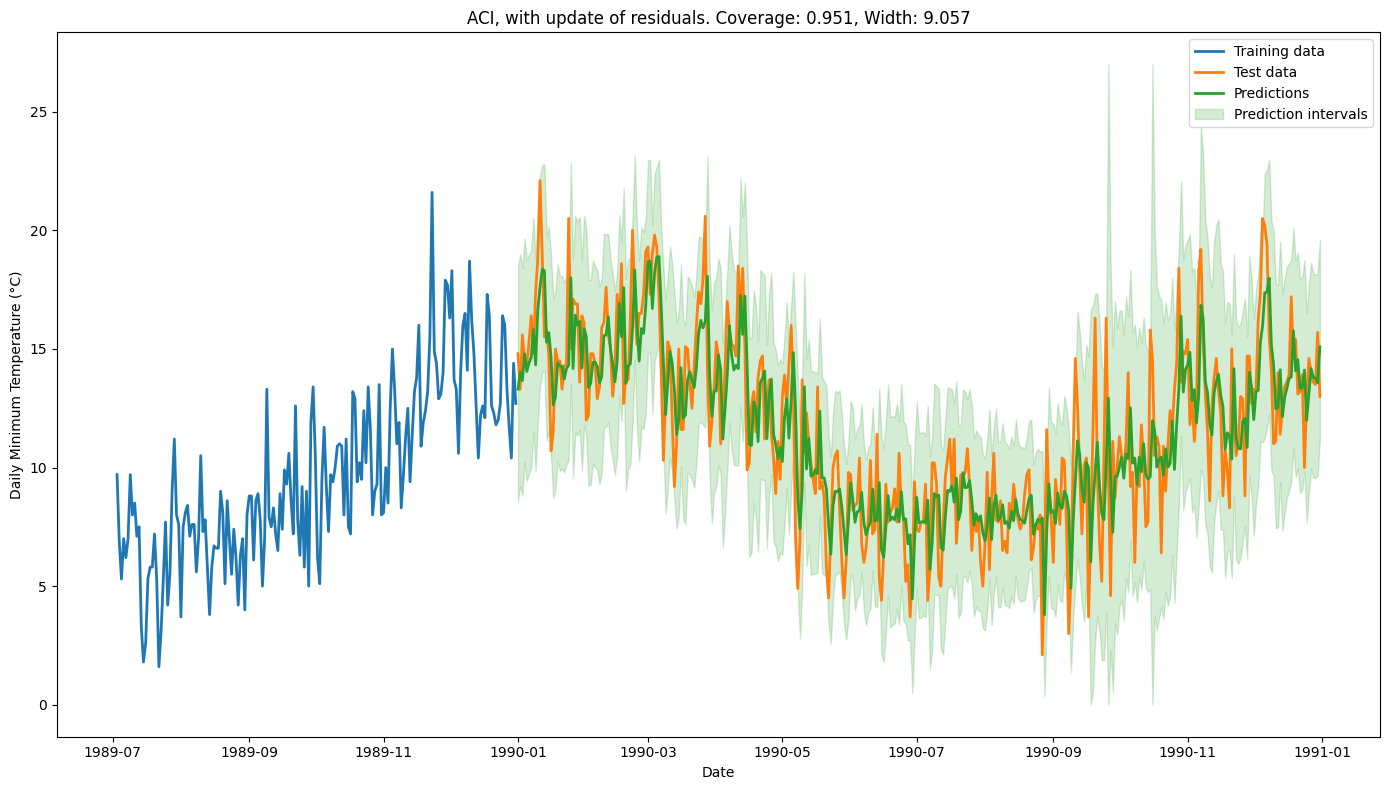

In [52]:
# Plotting for ACI
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.set_ylabel(y_label)
axs.set_xlabel(x_label)
axs.plot(y_train.index[int(-len(y_test)/2):], y_train[int(-len(y_test)/2):], lw=2, label="Training data", c="C0")
axs.plot(y_test.index, y_test, lw=2, label="Test data", c="C1")
axs.plot(y_test.index, y_aci_preds, lw=2, c="C2", label="Predictions")
axs.fill_between(
    y_test.index,
    y_aci_pis[:, 0, 0],
    y_aci_pis[:, 1, 0],
    color="C2",
    alpha=0.2,
    label="Prediction intervals",
)
title = f"ACI, with update of residuals. Coverage: {coverage_aci:.3f}, Width: {width_aci:.3f}"
axs.set_title(title)
axs.legend()
fig.tight_layout()
plt.show()